In [1]:
#|default_exp sgd

# Accelerated SGD

In [2]:
pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 13.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [8]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [9]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [10]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

TypeError: get_loss() missing 1 required positional argument: 'self'

## Optimizers

### SGD

In [8]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1 # track batch num
    # step and zero grad an optmizer baseline methods
    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [9]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.826,0.476,0,eval
0.845,0.424,1,train
0.850,0.417,1,eval
0.865,0.372,2,train
0.849,0.410,2,eval


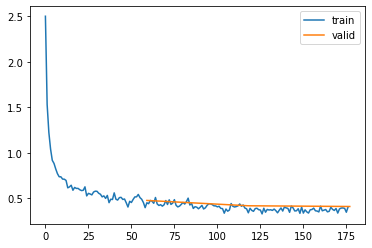

In [10]:
learn.fit(3)

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr*wd*weight
```

...vs...

``` python
weight.grad += wd*weight
```

### Momentum

In [11]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

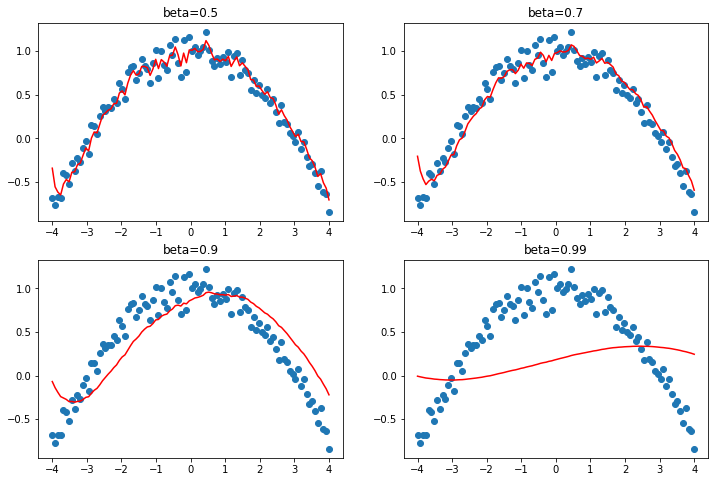

In [12]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [13]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad) # new attribute
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom) # whatever it used to be + current update
        p -= self.lr * p.grad_avg

In [14]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum) # we can hike the learning rate also, loss is a lot smoother

accuracy,loss,epoch,train
0.786,0.597,0,train
0.847,0.416,0,eval
0.868,0.359,1,train
0.858,0.375,1,eval
0.886,0.313,2,train
0.867,0.365,2,eval


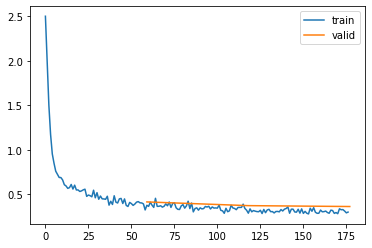

In [15]:
learn.fit(3)

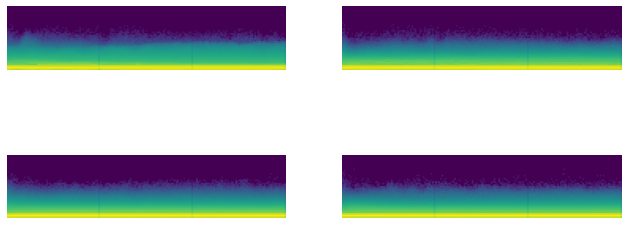

In [16]:
astats.color_dim()

### RMSProp

In [17]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.766,0.664,0,train
0.822,0.482,0,eval
0.848,0.416,1,train
0.846,0.425,1,eval
0.866,0.367,2,train
0.853,0.401,2,eval


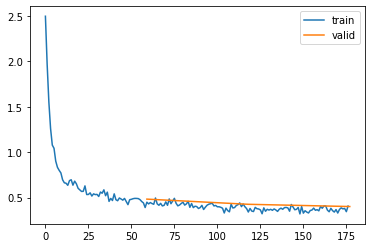

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

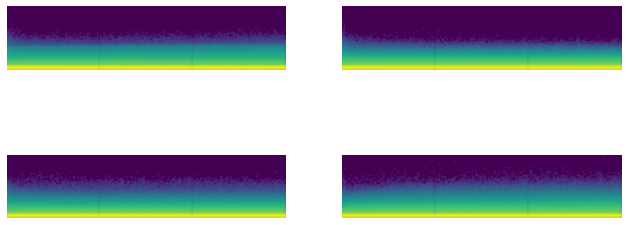

In [19]:
astats.color_dim()

### Adam

In [20]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5): # beta1->mom beta2->sqr mom (rmsprop)
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.583,0,train
0.839,0.428,0,eval
0.869,0.360,1,train
0.858,0.380,1,eval
0.886,0.312,2,train
0.874,0.345,2,eval


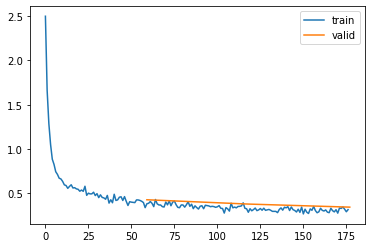

In [21]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

accuracy,loss,epoch,train
0.900,0.274,0,train
0.882,0.325,0,eval
0.904,0.266,1,train
0.882,0.322,1,eval


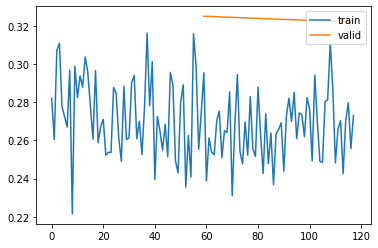

In [22]:
learn.fit(2,lr=6e-4)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [23]:
lr_scheduler

<module 'torch.optim.lr_scheduler' from '/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py'>

In [24]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [25]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [26]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [27]:
SingleBatchCB??

Init signature: SingleBatchCB()
Docstring:      <no docstring>
Source:        
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()
File:           /notebooks/miniai/learner.py
Type:           type
Subclasses:     


In [28]:
# a good way to test and look into learner is to use the single batch callback
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [29]:
learn.opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [30]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

In [31]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [32]:
# grab all params (only one group here)
# pytorch uses param tensors as keys and when you use then as keys
# you get its state
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [33]:
param.shape

torch.Size([8, 1, 3, 3])

In [34]:
st

{'momentum_buffer': None}

In [35]:
# parameter is a tensor, stored as keys
param

Parameter containing:
tensor([[[[ 0.33,  0.18, -0.04],
          [-0.31,  0.18, -0.31],
          [ 0.18,  0.06,  0.13]]],


        [[[ 0.10, -0.25, -0.14],
          [-0.07, -0.31,  0.22],
          [-0.16, -0.16, -0.12]]],


        [[[ 0.18, -0.00,  0.15],
          [ 0.17, -0.01,  0.27],
          [ 0.16,  0.19,  0.33]]],


        [[[ 0.13,  0.27,  0.18],
          [-0.14,  0.01, -0.17],
          [ 0.26,  0.10, -0.23]]],


        [[[ 0.30,  0.19,  0.02],
          [-0.24, -0.16, -0.30],
          [-0.22,  0.32, -0.02]]],


        [[[ 0.29,  0.17,  0.30],
          [ 0.11, -0.19,  0.31],
          [-0.28,  0.09,  0.09]]],


        [[[ 0.22, -0.24,  0.12],
          [ 0.04, -0.24,  0.05],
          [-0.03,  0.27, -0.31]]],


        [[[ 0.06,  0.31, -0.22],
          [ 0.31, -0.07,  0.29],
          [-0.04,  0.26, -0.32]]]], device='cuda:0', requires_grad=True)

In [36]:
# only one param group here, simple SGD
len(opt.param_groups)

1

In [37]:
pg = opt.param_groups[0]

In [38]:
# pg

In [39]:
# all the params in group (params) 
# and all the hyper params for each group lr, momemtum, weight decay...
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

In [40]:
# in pytorch a scheduler needs it's optmizer
# why? he needs to lear what optmizer it needs to change its Lr
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [41]:
[m for m in dir(sched) if not m.startswith("_")]

['T_max',
 'base_lrs',
 'eta_min',
 'get_last_lr',
 'get_lr',
 'last_epoch',
 'load_state_dict',
 'optimizer',
 'print_lr',
 'state_dict',
 'step',
 'verbose']

In [42]:
# gets this from the optmizer
sched.base_lrs

[0.006]

In [43]:
sched??

Type:        CosineAnnealingLR
String form: <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7f84c004ba30>
File:        /usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py
Source:     
class CosineAnnealingLR(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::
        \begin{aligned}
            \eta_t & = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1
            + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right),
            & T_{cur} \neq (2k+1)T_{max}; \\
            \eta_{t+1} & = \eta_{t} + \frac{1}{2}(\eta_{max} - \eta_{min})
            \left(1 - \cos\left(\frac{1}{T_{max}}\pi\right)\right),
            & T_{cur} = (2k+1)T_{max}.
        \end{aligned}

    When last_epoch=-1, sets initial lr as lr. Notice that because the schedule
    is defined r

In [44]:
sched_lrs??

Object `sched_lrs` not found.


In [45]:
# you can also the th emost recent lr
sched.get_last_lr()

[0.006]

In [46]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step() # this cases the scheduler to adjust its lr
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

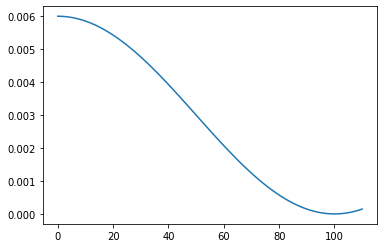

In [47]:
sched_lrs(sched, 110) # over 100 the cosine curve restarts

### Scheduler callbacks

In [98]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [57]:
#|export
class BatchSchedCB(BaseSchedCB):
    # if updates are required evr batch
    def after_batch(self, learn): self._step(learn)

NameError: name 'BaseSchedCB' is not defined

In [58]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [59]:
#|export
class RecorderCB(Callback):
    # to see what our Learner is doing
    def __init__(self, **d): 
        self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d} 
        self.pg = learn.opt.param_groups[0] # see _lr. We need to pick one param group to track, here first one
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            # import pdb; pdb.set_trace()
            # here the stats are recorded after batch
            # v is the function of interest, passed on d
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [60]:
def _lr(cb): return cb.pg['lr'] # function grabs what we needs for recorder cb

In [118]:
dls.train.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [119]:
len(dls.train) # number of batches per epoch

59

In [138]:
dls.train.batch_size

1024

In [139]:
1024 * 59

60416

In [142]:
tmax = 3 * len(dls.train) # 3 x total batch per epoch
print(tmax)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

177


In [143]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)

In [144]:
rec.d

{'lr': <function __main__._lr(cb)>}

accuracy,loss,epoch,train
0.806,0.525,0,train
0.848,0.414,0,eval
0.878,0.331,1,train
0.880,0.329,1,eval
0.897,0.282,2,train
0.881,0.317,2,eval


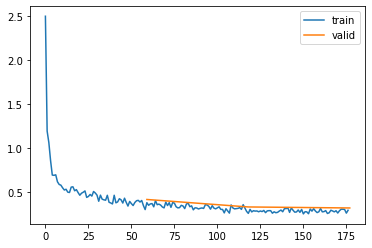

In [145]:
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

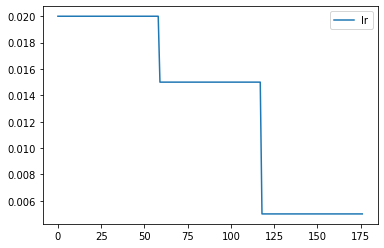

In [158]:
rec.plot()

In [160]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn) 

accuracy,loss,epoch,train
0.806,0.524,0,train
0.856,0.381,0,eval
0.880,0.328,1,train
0.870,0.335,1,eval
0.899,0.274,2,train
0.882,0.308,2,eval


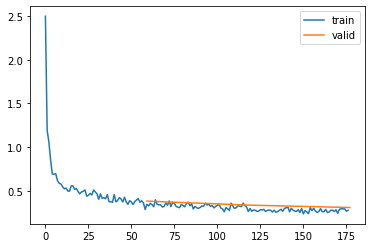

In [161]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3) # 3 epochs
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

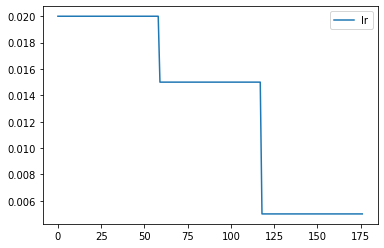

In [162]:
rec.plot()

In [157]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

TypeError: 'StepLR' object is not callable

In [84]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

NameError: name 'optimizer' is not defined

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [56]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.768,0.659,0,train
0.842,0.458,0,eval
0.857,0.389,1,train
0.854,0.419,1,eval
0.885,0.307,2,train
0.883,0.329,2,eval
0.907,0.250,3,train
0.899,0.279,3,eval
0.922,0.212,4,train
0.903,0.267,4,eval


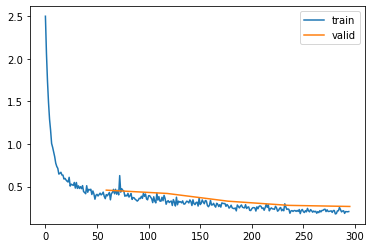

In [57]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

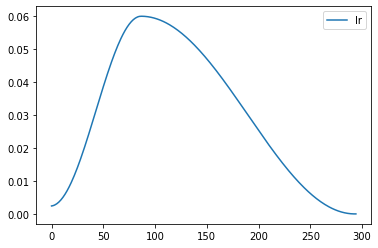

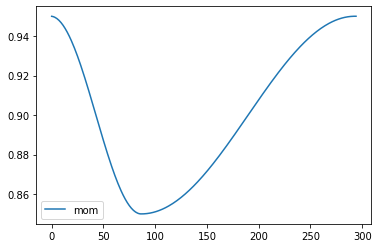

In [59]:
rec.plot()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()